## Amazon Customer Review Sentiment Analysis

In [55]:
#Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob   
import re
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
#Packages for model


#Packages for evaluation


#Filters and display options
import warnings
warnings.filterwarnings('ignore')
warnings.warn("text too long")
pd.set_option('display.max_columns', None)
%matplotlib inline
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartl\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [3]:
#Starting off by importing the csv file and reading the data
reviews = pd.read_csv('../data/amazon_reviews.csv', index_col=0)

In [32]:
#Creating a function for data frame summary statistics and viewing the data frame
def overview(df, head=5, tail=5):
   print("  TYPES   ".center(82, '-'))
   print(df.dtypes)
   
   print("  SHAPE   ".center(82,'-'))
   print(f"Rows: {df.shape[0]}")
   print(f"Columns: {df.shape[1]}")
   
   print("  DUPLICATES  ".center(82,'-'))
   print(df.duplicated().sum())
   
   print("  NaN VALUES".center(82,'-'))
   print(df.isna().sum())
   
   print("  QUANTILES   ".center(82,'-'))
   print(df.quantile([0,0.05,0.50,0.95,0.99,1]).T)
   
   print("  DATAFRAME PREVIEW   ".center(82, '-'))
   print(df.head(n=5))
   print(df.tail(n=5))

In [42]:
#Calling the function
overview(reviews)

------------------------------------  TYPES   ------------------------------------
reviewerName             object
overall                  object
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
------------------------------------  SHAPE   ------------------------------------
Rows: 4914
Columns: 11
----------------------------------  DUPLICATES  ----------------------------------
0
-----------------------------------  NaN VALUES-----------------------------------
reviewerName            0
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_boun

Based on the overview function call, we can see that most of the data frame columns are either int or float types. I can also see that there are 4915 rows spanning across 12 columns of data. As for null values there appear to only be 2, so there won't be much cleaning up to do of null values in this data set at first glance. I'm also viewing the first 5 and last 5 rows of the data frame to get a general understanding of what's contained in the data. Based on the nature of the data, it looks like the 'overall' column can be used as the target variable. The float type will be replaced with string values, 0-2 will be seen as negative, 3 will be neutral and 4-5 will be positive.

## Step 1:
Remove any NaN values

In [39]:
#Taking a look at the NaN value before replacing it 
reviews['reviewerName'].head()

0      randomName
1            0mie
2             1K3
3             1m2
4    2&amp;1/2Men
Name: reviewerName, dtype: object

Since the only NaN value in this column is a customer name, we will assign a random name to the customer. This step is be taken since the reviewernames have no affect on our dataset. 

In [38]:
reviews['reviewerName'].fillna('randomName', inplace=True)

Next up is the reviewText column, since the contents of this column are going to be used later to perform sentiment analysis, any NaN values here will have to be dropped instead of replaced. To do this, I'm going to drop the entire row that contains the NaN value. 

In [41]:
reviews.dropna(inplace=True)

## Step 2:
Convert the float column 'overall' to sentiment string values 

In [7]:
#Creating a simple function to return sentiment type
def sentimentType(score):
    if score == 4.0 or score == 5.0:
        return 'Positive'
    elif score == 3.0:
        return 'Neutral'
    elif score == 1.0 or score == 2.0:
        return 'Negative'

In [8]:
#Applying the function created earlier to the overall column
reviews['overall'] = reviews['overall'].apply(sentimentType)
reviews.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,NaN,Positive,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,0mie,Positive,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,1K3,Positive,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,1m2,Positive,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,2&amp;1/2Men,Positive,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


Text(0.5, 0, 'Sentiment Type')

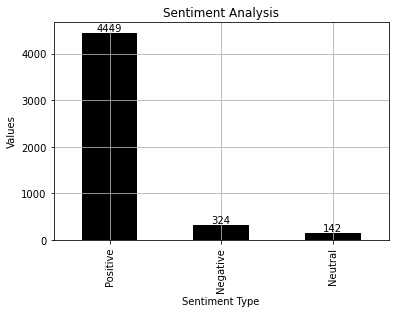

In [23]:
#Visualizing the data after converting overall column to string values 
ax = reviews['overall'].value_counts().plot(kind='bar', grid=True, colormap='gray')
ax.bar_label(ax.containers[0])
plt.title('Sentiment Analysis')
plt.ylabel('Values')
plt.xlabel('Sentiment Type')

## Step 3:
Explore the reviewText column and convert to string type/lower case 

In [47]:
#Converting the values in reviewText to string values and changing the case to lower
reviews['reviewText'] = reviews['reviewText'].astype(str).apply(lambda text: text.lower())

In [50]:
stop_words = set(stopwords.words("english"))

def text_processing(text):
    text = re.sub(r"https?\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text_tokens = word_tokenize(text.lower())
    filtered_text = [i for i in text_tokens if i not in stop_words]
    return " ".join(filtered_text)

In [56]:
reviews["reviewText"] = reviews['reviewText'].apply(text_processing)